<a href="https://colab.research.google.com/github/aherrera3/thesis/blob/main/Fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.odr as odr
from glob import glob
import re
from tqdm import tqdm

np.seterr(all="ignore") # Set how floating-point errors are handled: ignore invalid float operations
plt.rcParams["figure.dpi"] = 130 # Set the resolution to all figures in dots-per-inch

### Clone the GitHub repository containing the data .csv

In [ ]:
!git clone https://github.com/aherrera3/qcdnum-17-01-14

Cloning into 'qcdnum-17-01-14'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 143 (delta 15), reused 136 (delta 12), pack-reused 0
Receiving objects: 100% (143/143), 1.12 MiB | 16.89 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [ ]:
!ls

qcdnum-17-01-14  sample_data


### Functions

In [ ]:
# PDFs parametrization
def model(B, x):
    tolerance = 1e-6
    return (1-x+tolerance)**B[2] * x**B[1] * B[0] * (1 + B[3]*x + B[4]*x**2 + B[5]*np.log(x) + B[6]*np.log(x)**2)

# Get the Q2 value of the namefile
def parse_filename_Q2(fname):
    return float(re.search("(?<=_)[\d\.*]+(?=.csv)",fname).group(0))

# Fit function
def odr_fit(data:pd.DataFrame, variable:str, initial_parameters:np.array):
    return odr.ODR(
        odr.Data(data["x"].values, data[var].values),
        odr.Model(model),
        beta0=initial_parameters,
        maxit=5000,
        ifixx=np.zeros(len(data["x"]))
    ).run()

### Create output directories

In [ ]:
filenames = glob("qcdnum-17-01-14/output/*")
filenames.sort(key=parse_filename_Q2)
variables = ['xuv', 'xdv', 'xubar', 'xdbar', 'xgl']
for var in variables:
    os.makedirs(f"./img/{var}", exist_ok=True)
os.makedirs("./img/parameters", exist_ok=True)
filenames

['qcdnum-17-01-14/output/pruebaCxx_q2_2.560000.csv',
 'qcdnum-17-01-14/output/pruebaCxx_q2_4.499704.csv',
 'qcdnum-17-01-14/output/pruebaCxx_q2_7.909116.csv',
 'qcdnum-17-01-14/output/pruebaCxx_q2_13.901828.csv',
 'qcdnum-17-01-14/output/pruebaCxx_q2_24.435199.csv',
 'qcdnum-17-01-14/output/pruebaCxx_q2_42.949673.csv',
 'qcdnum-17-01-14/output/pruebaCxx_q2_75.492506.csv',
 'qcdnum-17-01-14/output/pruebaCxx_q2_132.692941.csv',
 'qcdnum-17-01-14/output/pruebaCxx_q2_233.233967.csv',
 'qcdnum-17-01-14/output/pruebaCxx_q2_409.954613.csv',
 'qcdnum-17-01-14/output/pruebaCxx_q2_720.575940.csv',
 'qcdnum-17-01-14/output/pruebaCxx_q2_1266.554074.csv',
 'qcdnum-17-01-14/output/pruebaCxx_q2_2226.218132.csv',
 'qcdnum-17-01-14/output/pruebaCxx_q2_3913.016640.csv',
 'qcdnum-17-01-14/output/pruebaCxx_q2_6877.897098.csv',
 'qcdnum-17-01-14/output/pruebaCxx_q2_12089.258196.csv',
 'qcdnum-17-01-14/output/pruebaCxx_q2_21249.251283.csv',
 'qcdnum-17-01-14/output/pruebaCxx_q2_37349.742456.csv',
 'qcdnum-1

### Fit every pdf of every .csv with the model

In [ ]:
def fit_and_figures(var, fname, beta0, show):
    data = pd.read_csv(fname, sep=" ")

    fit = odr_fit(data, data[var], beta0)   
    fitted_model = model(fit.beta, data["x"])

    #saving the info into temporary dics
    parameters[parse_filename_Q2(fname)] = pd.Series(fit.beta, name="Beta", index=list("abcdefg"))
    max_residual[parse_filename_Q2(fname)] = max(abs(fitted_model-data[var]))

    # figures
    fig, ax = plt.subplots(
        nrows=2,                                # set two horizontal axes
        figsize=(7,7),
        #dpi=150,
        sharex=True,                            # x axis will be shared among all subplots.
        gridspec_kw={"height_ratios":[4,2]}     # different size for upper and bottom axes
    )

    # upper graph: the fits
    plt.sca(ax[0])                                    # set the current axes to axis=0
    plt.title(f"$Q^2 = {parse_filename_Q2(fname):.3e}$", fontsize=20)
    plt.plot(data["x"], fitted_model, c='k', linestyle=(0,(5,5)), label="fitted data")
    plt.scatter(data["x"], data[var], s=3, label="original data")
    plt.ylabel(var, fontsize=18)
    plt.legend()

    # bottom graph: the residuals
    plt.sca(ax[1])                                    # set the current axes to axis=1
    plt.scatter(data["x"], fitted_model-data[var], s=3)
    plt.xlabel("x", fontsize=15)

    #fig.suptitle("Residuals")
    plt.xscale("log")
    plt.tight_layout()                                # 
    plt.savefig(f"./img/{var}/q2_{parse_filename_Q2(fname)}.png")
    plt.show() if show else plt.close()

In [ ]:
residuals = {}
results = []

# runs for every variable xpdf
for var in variables:
    parameters = {}
    max_residual = {}

    beta0 = np.ones(7) if var=="xdv" else np.ones(7)*0.5 if var=="xubar" else np.zeros(7)

    # runs for every .csv
    for i,fname in tqdm(enumerate(filenames), desc=var, total=(len(filenames))):
        fit_and_figures(var, fname, beta0, show=False)
    
    # for each xpdf
    results.append(pd.concat(parameters).rename(var))
    residuals[var] = max_residual

xgl: 100%|██████████| 35/35 [00:41<00:00,  1.17s/it]


### Results

In [ ]:
# Fitted results
fit_results = pd.concat(results, axis=1)
fit_results.index.names = ["Q^2","par"]
fit_results.sort_index(inplace=True)
fit_results.head(14)

xuv        xdv      xubar      xdbar         xgl
Q^2      par                                                       
2.560000 a    0.967722   1.485324   1.524408   4.204799  132.332392
         b    0.051236   0.003117   0.116444   0.178214    0.500372
         c    1.946228   6.242117  10.947344  15.280354   11.739604
         d    4.089232  -2.091753   0.528149  -3.659360   -2.584313
         e   -6.574460  18.822663  -0.389818   5.384425    4.837809
         f    0.171287   0.218153   0.274980   0.300742    0.459485
         g    0.028720   0.022063   0.042313   0.036063    0.066721
4.499704 a    0.988111   1.420861   2.092522   4.088064   76.796190
         b    0.050223  -0.002337   0.146939   0.174596    0.408835
         c    1.996650   6.291205   6.128846  15.441715   10.998220
         d    3.900729  -2.014615  -2.546241  -3.671232   -2.476842
         e   -6.346898  19.083888   1.990242   5.563994    4.715526
         f    0.174031   0.213740   0.307638   0.300247    0.459075
         g    0.029013   0.021769   0.045121   0.036349    0.069473

In [ ]:
# Residuals
max_residuals = pd.DataFrame.from_dict(residuals)
max_residuals.index.name = "Q^2"
max_residuals.sort_index(inplace=True)
max_residuals

,xuv,xdv,xubar,xdbar,xgl
Q^2,,,,,
2.560000e+00,0.010395,0.006280,0.000067,0.000293,0.055959
4.499704e+00,0.009566,0.006096,0.000372,0.000221,0.040944
7.909116e+00,0.008834,0.005926,0.000277,0.000158,0.031741
1.390183e+01,0.008176,0.005787,0.000196,0.000105,0.025456
2.443520e+01,0.007642,0.005658,0.000156,0.000106,0.020990
4.294967e+01,0.007201,0.005533,0.000131,0.000125,0.017703
7.549251e+01,0.006802,0.005414,0.000110,0.000141,0.015234
1.326929e+02,0.006441,0.005298,0.000091,0.000156,0.013321
2.332340e+02,0.006111,0.005187,0.000076,0.000169,0.011784


### Violin plots for residuals 

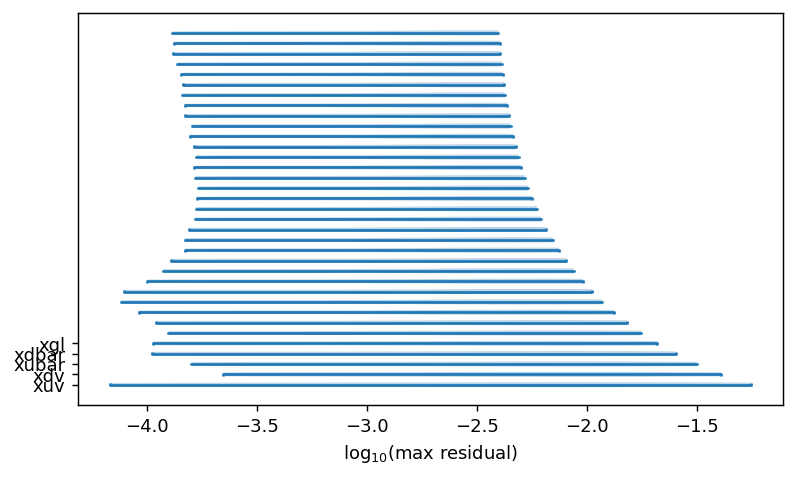

In [ ]:
plt.figure(figsize=(7,4))
plt.violinplot(np.log10(max_residuals), vert=False)
plt.yticks(ticks=range(1,6), labels=max_residuals.columns)
plt.xlabel(r"$\log_{10}($max residual$)$")
plt.savefig("img/violin_residual.png", dpi=300)

In [ ]:
type(fit_results)

pandas.core.frame.DataFrame

In [ ]:
"""
 he probado con:
 - 0.3: se descuadran los 3 primeros
 - 0.6: maso, primer punto falla
 - 0.4: igual que arriba
 - 0.8: terrible
 - 0.5
"""

'\n he probado con:\n - 0.3: se descuadran los 3 primeros\n - 0.6: maso, primer punto falla\n - 0.4: igual que arriba\n - 0.8: terrible\n - 0.5\n'

### Comparing with paper parameters

In [ ]:
initial_conditions = pd.DataFrame(
    {
      #            a        ,   b  ,    c ,  d  ,  e ,  f    ,   g
      'xuv':[10.19304899633023, 0.76,   4.6, 0.0 , 2.6, 0.35  , 0.049],
     'xdv': [5.564255181349489, 0.99,   4.7, 0.0 , 0.0, 0.0   , 0.0],
     'xubar':[    0.14        , -0.33,  11 , 18  , 0.0, 0.071 , 0.0],
     'xdbar':[    0.14        , -0.33,  24 , 38  , 0.0, 0.071 , 0.0],
     'xgl':[0.872978687751462, -0.52,  4.5, 0.0 , 0.0, 0.217 , 0.0112]
    },

    index = ["a", "b", "c", "d", "e", "f", "g"]
)

initial_conditions

,xuv,xdv,xubar,xdbar,xgl
a,10.193049,5.564255,0.140,0.140,0.872979
b,0.760000,0.990000,-0.330,-0.330,-0.520000
c,4.600000,4.700000,11.000,24.000,4.500000
d,0.000000,0.000000,18.000,38.000,0.000000
e,2.600000,0.000000,0.000,0.000,0.000000
f,0.350000,0.000000,0.071,0.071,0.217000
g,0.049000,0.000000,0.000,0.000,0.011200


a    10.193049
b     0.760000
c     4.600000
d     0.000000
e     2.600000
f     0.350000
g     0.049000
Name: xuv, dtype: float64 

Fit of  qcdnum-17-01-14/output/pruebaCxx_q2_2.560000.csv


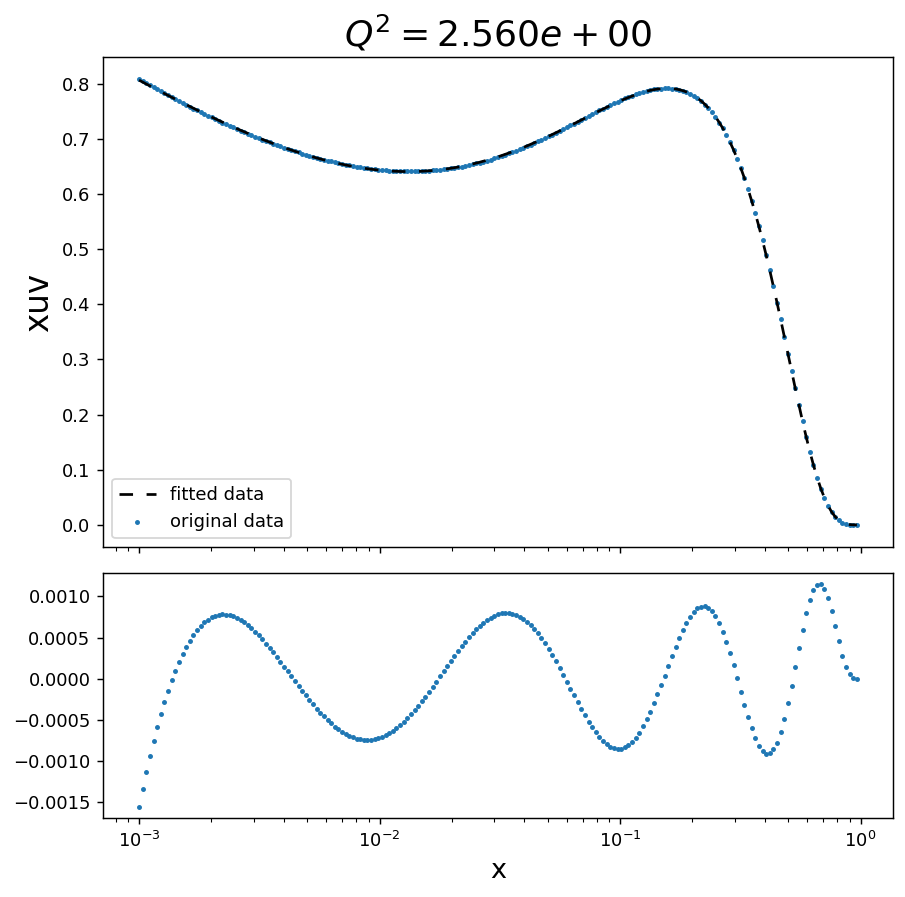

Fit of  qcdnum-17-01-14/output/pruebaCxx_q2_544923149.022954.csv


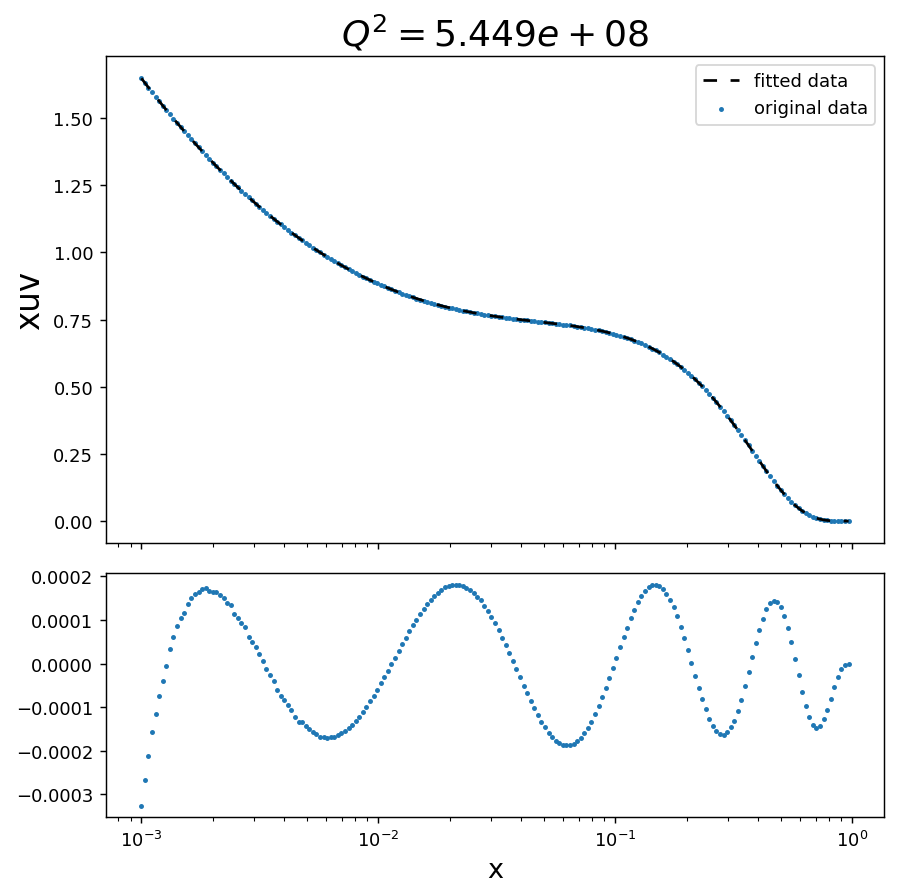

In [ ]:
# comparing uv and dbar using the first and last .csv files
var = "xuv"
initial_parameters = initial_conditions[var]
print(initial_parameters, "\n")

for fname in (filenames[0], filenames[-1]):
    print("Fit of ", fname)
    fit_and_figures(var, fname, initial_parameters, show=True)

## Parameters

### Graphs for the fitted parameters

100%|██████████| 7/7 [00:05<00:00,  1.33it/s]


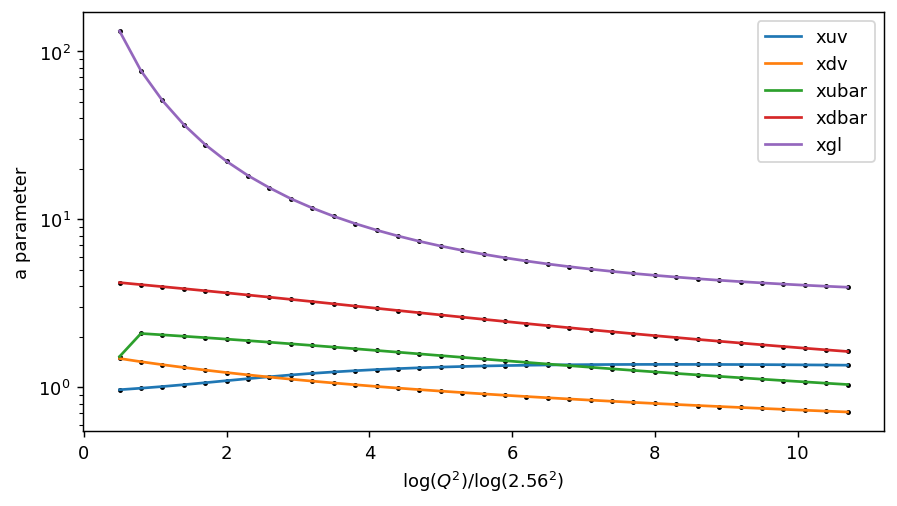

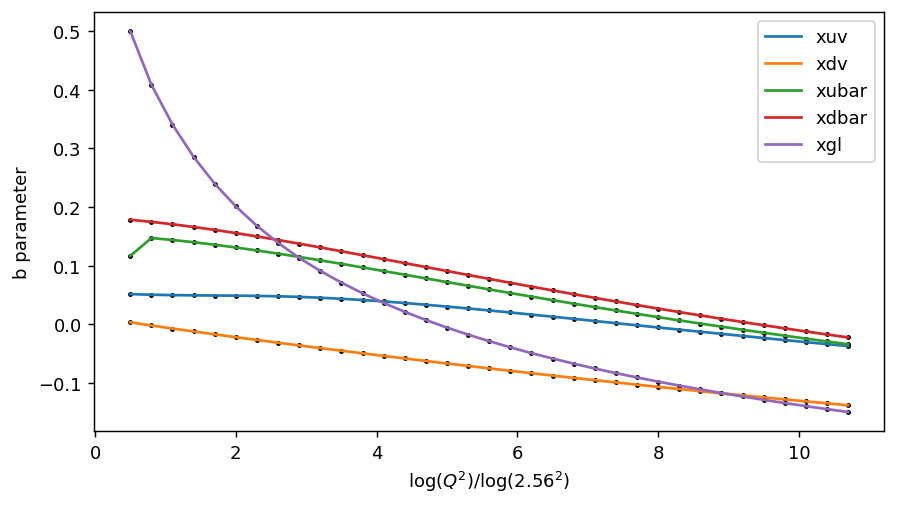

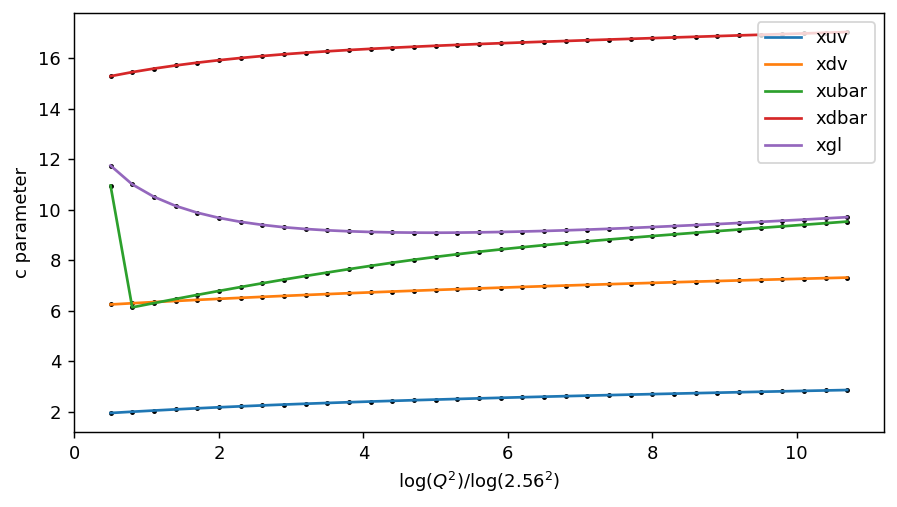

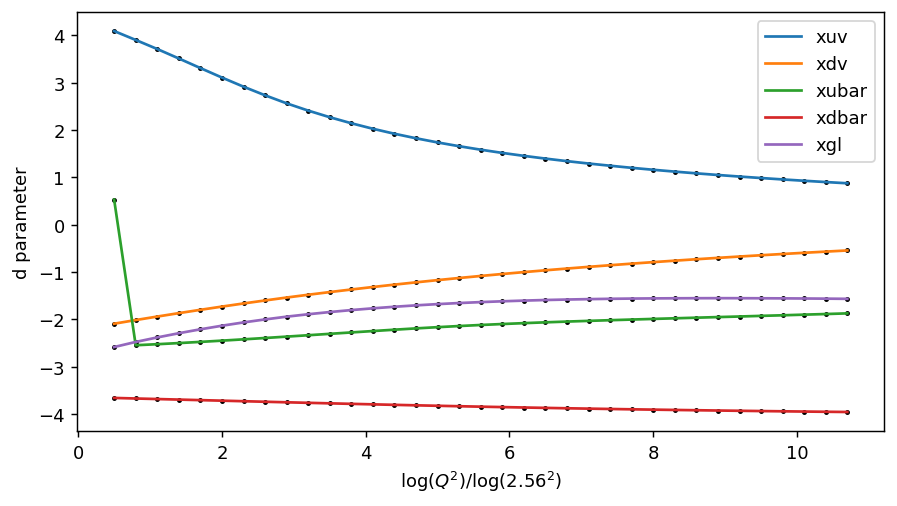

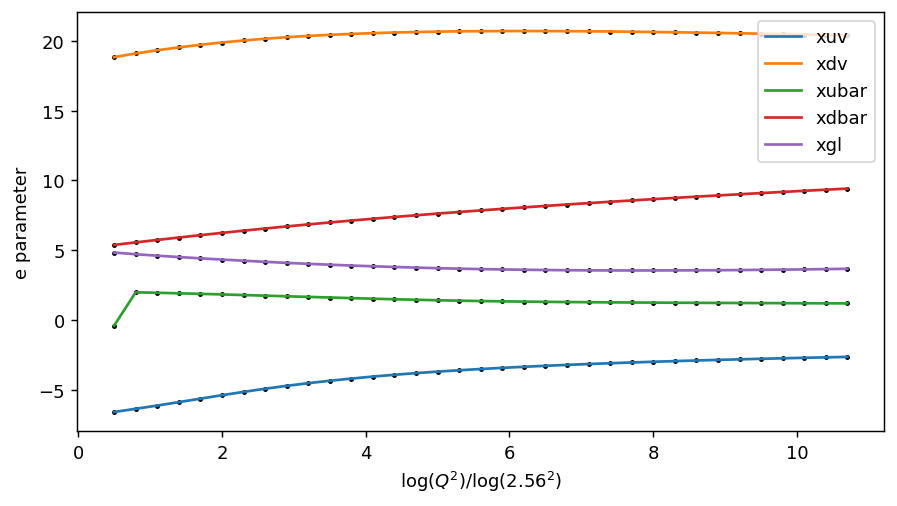

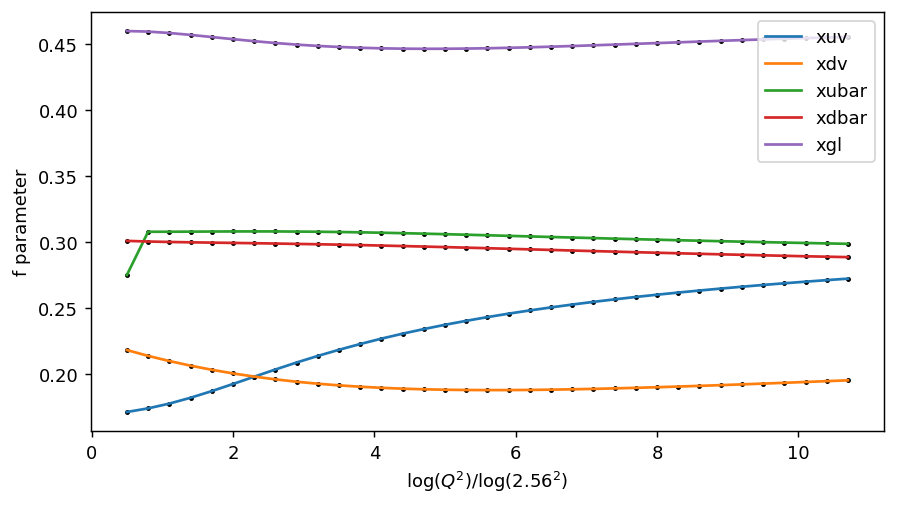

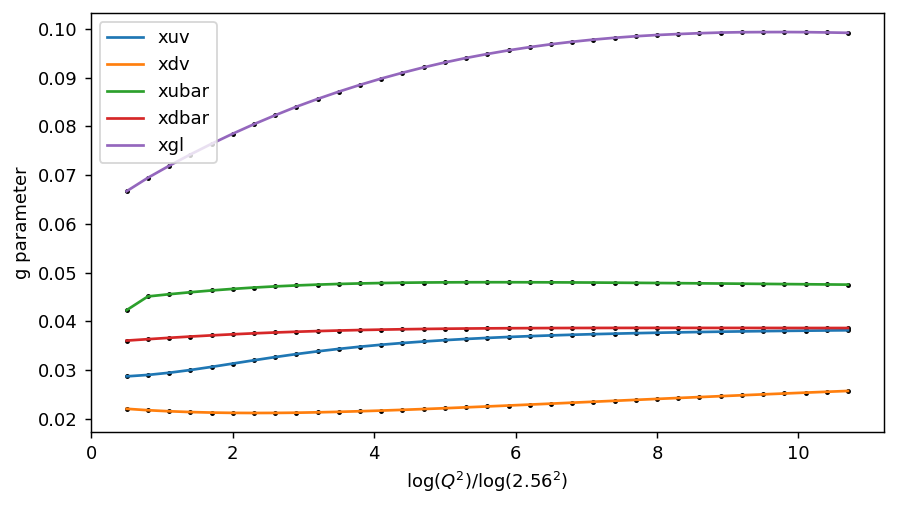

In [ ]:
for par in tqdm("abcdefg"):
    plot_df = fit_results.xs(par, level=1)          # cross-section??
    ptp = plot_df.values.ptp()
    xmin = plot_df.values.min()
    xmax = plot_df.values.max()
    plot_df = plot_df.reset_index()
    label = r"$\log(Q^2) / \log(2.56^2)$"
    plot_df[label] = np.log(plot_df["Q^2"])/np.log(2.56**2)

    plt.figure(figsize=(7,4))
    for y in fit_results.columns:
        plot_df.plot.scatter(x=label, y=y, ax=plt.gca(), c='k', s=3)
    plot_df.plot(x=label, y=fit_results.columns, ylabel=f"{par} parameter", ax=plt.gca())
    if ptp > 30:
        plt.yscale("log" if xmin>0 else "symlog")
    plt.tight_layout()
    plt.savefig(f"img/parameters/{par}.png",dpi=300)
    #plt.close()

### Fitting the parameters